# Logic till yet:

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, BatchNormalization, Dropout, Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Data preprocessing
def preprocess_data(df):
    try:
        # Process temporal features
        df['Seconds'] = df.index.map(pd.Timestamp.timestamp)
        
        day = 24 * 60 * 60
        year = (365.2425) * day
        
        # Add cyclical time features
        df['Day sin'] = np.sin(df['Seconds'] * (2 * np.pi / day))
        df['Day cos'] = np.cos(df['Seconds'] * (2 * np.pi / day))
        df['Year sin'] = np.sin(df['Seconds'] * (2 * np.pi / year))
        df['Year cos'] = np.cos(df['Seconds'] * (2 * np.pi / year))
        
        df = df.bfill()
        df = df.drop(['Seconds'], axis=1)
        
        return df
    except Exception as e:
        print(f"Error in preprocess_data: {e}")
        raise

def df_to_X_y(df, window_size=24):
    try:
        df_as_np = df.to_numpy()
        X = []
        y = []
        
        for i in range(len(df_as_np) - window_size):
            row = [r for r in df_as_np[i: i + window_size]]
            X.append(row)
            
            label = df_as_np[i + window_size][0]
            y.append(label)
        
        return np.array(X), np.array(y)
    except Exception as e:
        print(f"Error in df_to_X_y: {e}")
        raise

def split_time_series_data(X, y, train_ratio=0.8, val_ratio=0.1):
    try:
        n = len(X)
        train_end = int(n * train_ratio)
        val_end = train_end + int(n * val_ratio)

        X_train, y_train = X[:train_end], y[:train_end]
        X_val, y_val = X[train_end:val_end], y[train_end:val_end]
        X_test, y_test = X[val_end:], y[val_end:]

        return X_train, X_val, X_test, y_train, y_val, y_test
    except Exception as e:
        print(f"Error in split_time_series_data: {e}")
        raise

def standardize_features(X_train, X_val, X_test):
    """
    Standardize all features in the dataset while maintaining the 3D structure
    (samples, timesteps, features).
    """
    num_samples, num_timesteps, num_features = X_train.shape
    
    # Reshape to 2D for StandardScaler (combine samples & timesteps)
    X_train_reshaped = X_train.reshape(-1, num_features)
    
    # Fit the scaler on training data only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_reshaped)

    # Transform validation and test sets
    X_val_scaled = scaler.transform(X_val.reshape(-1, num_features))
    X_test_scaled = scaler.transform(X_test.reshape(-1, num_features))

    # Reshape back to original 3D shape
    X_train = X_train_scaled.reshape(num_samples, num_timesteps, num_features)
    X_val = X_val_scaled.reshape(X_val.shape[0], X_val.shape[1], num_features)
    X_test = X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], num_features)

    return X_train, X_val, X_test, scaler


# Model architectures with regularization and dropout
def create_lstm_model(input_shape, dropout_rate=0.3):
    try:
        model = Sequential([
            InputLayer(shape=input_shape),
            
            LSTM(
                128, 
                return_sequences=True, 
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                recurrent_regularizer=l1_l2(l1=1e-5, l2=1e-4)
            ),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            LSTM(
                64, 
                return_sequences=False,
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)
            ),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            Dense(
                32, 
                activation='relu',
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)
            ),
            Dropout(dropout_rate),
            
            Dense(1, activation='linear')
        ])
        return model
    except Exception as e:
        print(f"Error in create_lstm_model: {e}")
        raise

def create_gru_model(input_shape, dropout_rate=0.3):
    try:
        model = Sequential([
            InputLayer(shape=input_shape),
            
            GRU(
                128, 
                return_sequences=True,
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)
            ),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            GRU(
                64, 
                return_sequences=False,
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)
            ),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            Dense(
                32, 
                activation='relu',
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)
            ),
            Dropout(dropout_rate),
            
            Dense(1, activation='linear')
        ])
        return model
    except Exception as e:
        print(f"Error in create_gru_model: {e}")
        raise

# Weighted mean squared error
def weighted_mse(y_true, y_pred):
    try:
        weights = tf.where(y_pred < y_true, 2.0, 1.0) # Penalize underestimation more heavily (false negatives)
        squared_difference = tf.square(y_true - y_pred)
        return tf.reduce_mean(weights * squared_difference)
    except Exception as e:
        print(f"Error in weighted_mse: {e}")
        raise


# Training function with callbacks
def train_model(model, X_train, y_train, X_val, y_val, model_path, 
                batch_size=32, epochs=5, patience=3, learning_rate=1e-3):
    try:
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, start_from_epoch=3),
            ModelCheckpoint(model_path, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=patience, min_lr=1e-6)
        ]
        
        model.compile(
            optimizer=AdamW(learning_rate=learning_rate, weight_decay=1e-4),
            loss=weighted_mse,
            metrics=[
                'mse', 
                'mae',
                'root_mean_squared_error',
            ]
        )
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )
        return history
    except Exception as e:
        print(f"Error in train_model: {e}")
        raise


def evaluate_model(model, X_test, y_test, threshold=0.5):
    """
    Evaluates a time series forecasting model with focus on false negatives
    and additional metrics (CSI, POD, FAR, Precision, Recall, F1-score)
    using TensorFlow.

    Args:
        model (tf.keras.Model): Trained TensorFlow Keras model.
        X_test (np.ndarray or tf.Tensor): Test data features.  (Assumed already a tensor or convertible)
        y_test (np.ndarray or tf.Tensor): Test data labels (actual values). (Assumed already a tensor or convertible)
        threshold (float): Threshold to define a cloudburst event.

    Returns:
        dict: A dictionary of evaluation metrics (all TensorFlow tensors).
    """
    try:
        # Ensure X_test and y_test are TensorFlow tensors
        X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
        y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

        predictions = model.predict(X_test)  # model.predict returns numpy array

        # Convert predictions to a TensorFlow tensor
        predictions = tf.convert_to_tensor(predictions.flatten(), dtype=tf.float32)

        # Compute MSE and MAE (using TensorFlow)
        mse = tf.reduce_mean((y_test - predictions)**2)
        mae = tf.reduce_mean(tf.abs(y_test - predictions))

        # Compute RMSE (using TensorFlow)
        rmse = tf.sqrt(mse)  # RMSE is the square root of MSE

        # Convert to binary labels (using TensorFlow)
        binary_actual = tf.cast(y_test > threshold, tf.float32)
        binary_pred = tf.cast(predictions > threshold, tf.float32)

        # Calculate True Positives, False Positives, False Negatives, True Negatives
        tp = tf.reduce_sum(binary_actual * binary_pred)
        fp = tf.reduce_sum((1 - binary_actual) * binary_pred)
        fn = tf.reduce_sum(binary_actual * (1 - binary_pred))
        tn = tf.reduce_sum((1 - binary_actual) * (1 - binary_pred))

        # Handle division by zero
        epsilon = 1e-7  # Small constant to prevent division by zero

        # Compute additional metrics (using TensorFlow)
        csi = tp / (tp + fn + fp + epsilon)
        pod = tp / (tp + fn + epsilon)
        far = fp / (tp + fp + epsilon)
        precision = tp / (tp + fp + epsilon)
        recall = tp / (tp + fn + epsilon)  # This is the same as POD
        f1 = 2 * (precision * recall) / (precision + recall + epsilon)

        # Compute false negative rate (using TensorFlow)
        total_positives = tf.reduce_sum(tf.cast(y_test > threshold, tf.float32))
        false_negatives = tf.cast(fn, tf.float32) #Cast to float32 for division
        false_negative_rate = false_negatives / (total_positives + epsilon)

        return {
            'mse': mse,
            'mae': mae,
            'rmse': rmse,
            'false_negative_rate': false_negative_rate,
            'CSI': csi,
            'POD': pod,
            'FAR': far,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        }
    except Exception as e:
        print(f"Error in evaluate_model: {e}")
        raise #Re-raise the exception

def plot_predictions(model, X_data, y_data, label, start=50, end=500, ylabel='Rainfall (mm)', title_suffix=''):
    # Make predictions
    predictions = model.predict(X_data).flatten()

    # Create a DataFrame to store results
    results_df = pd.DataFrame(data={f'{label} Predictions': predictions, 'Actual Values': y_data})
    print(results_df)

    # Plot the predictions and actual values
    plt.figure(figsize=(10, 6))
    plt.plot(results_df[f'{label} Predictions'][start:end], label=f'{label} Predictions', color='blue', linestyle='-')
    plt.plot(results_df['Actual Values'][start:end], label='Actual Values', color='orange', linestyle='--')

    # Add labels and title
    plt.xlabel('Time Stamps', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(f'{label} Predictions vs Actual Values {title_suffix}', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True)
    # plt.show()

    return results_df


# Main execution
def main():
    try:
        # Load and preprocess data
        df = pd.read_csv('../artifacts/dataset/01-hourly_historical_analyzed_data.csv')
        df = df.drop(columns=['hour', 'day', 'month', 'year'])
        
        # Convert to datetime index
        df1 = df.copy()
        df1.index = pd.to_datetime(df1['time'], format='%Y-%m-%d %H:%M:%S')
        
        print("********DATA INGESTION COMPLETE********")
        
        # Extract rain data
        rain = df1['rain']
        rain_df = pd.DataFrame(rain)
        
        # Preprocess data with enhanced features
        rain_df = preprocess_data(rain_df)
        rain_df = rain_df.drop(['rain'], axis=1)
        
        processed_df = pd.concat([df1, rain_df], axis=1)
        processed_df = processed_df.drop(['time'], axis=1)
        
        # Create sequences
        X, y = df_to_X_y(processed_df, window_size=24)
        
        # Split data
        X_train, X_val, X_test, y_train, y_val, y_test = split_time_series_data(X, y)
        
        # Scale the data
        X_train, X_val, X_test, X_scaler = standardize_features(X_train, X_val, X_test)
        
        print("********DATA PREPROCESSING COMPLETE********")
        
        # Train models
        models = {
            'lstm': create_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2])),
            'gru': create_gru_model(input_shape=(X_train.shape[1], X_train.shape[2])),
        }
        
        # Create a directory for the results
        results_dir = f'../artifacts/results/cycle_3/test_1/'
        os.makedirs(results_dir, exist_ok=True)
        
        results = {}
        for name, model in models.items():
            print(f"\nTraining {name.upper()} model...")

            try:
                history = train_model(
                    model, X_train, y_train, X_val, y_val,
                    f'../artifacts/models/cycle_3/test_1/model_{name}.keras', 
                    epochs=10, earning_rate=1e-3
                )

                print("********MODEL TRAINING COMPLETE********")
            except Exception as e:
                print(f"Error training {name.upper()} model: {e}")
                continue
                
            try:
                results[name] = evaluate_model(model, X_test, y_test)
            except Exception as e:
                print(f"Error evaluating {name.upper()} model: {e}")
                continue
                    
            # Save training history to CSV
            history_df = pd.DataFrame(history.history)
            history_df.to_csv(os.path.join(results_dir, f'{name}_history.csv'), index=False)
            
            # Plot training history
            plt.figure(figsize=(10, 6))
            plt.plot(history.history['loss'], label='Training Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title(f'{name.upper()} Model Training History')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.savefig(os.path.join(results_dir, f'{name}_training_history.png'))
            # plt.show()
            plt.close()  # Close the plot to free memory
            
            # Save evaluation results to a text file
            with open(os.path.join(results_dir, f'{name}_evaluation.txt'), 'w') as f:
                for metric_name, value in results[name].items():
                    f.write(f"{metric_name}: {value:.4f}\n")
            
            # Plot predictions for Train, Val, and Test datasets and save the plots
            for dataset, data, true_values in zip(['Train', 'Val', 'Test'], 
                                                [X_train, X_val, X_test], 
                                                [y_train, y_val, y_test]):
                plot_predictions(
                    model=model, 
                    X_data=data, 
                    y_data=true_values, 
                    label=name + ' ' + dataset, 
                    start=100, 
                    end=500
                )
                plt.savefig(os.path.join(results_dir, f'{name}_{dataset.lower()}_predictions.png'))
                # plt.show()
                plt.close()  # Close the plot to free memory
                
            print("********MODEL EVALUATION COMPLETE********")
            
        print(f"Results saved in '{results_dir}'.")
            
        # Return results
        return results
    except Exception as e:
        print(f"Error in main: {e}")
        raise

if __name__ == "__main__":
    try:
        results = main()
        print("\nModel Evaluation Results:")
        for model_name, metrics in results.items():
            print(f"\n{model_name.upper()}:")
            for metric_name, value in metrics.items():
                print(f"{metric_name}: {value:.4f}")
    except Exception as e:
        print(f"Unhandled error in execution: {e}")

********DATA INGESTION COMPLETE********
********DATA PREPROCESSING COMPLETE********
Directory created: ../artifacts/results/cycle_3/test_1/lstm
Directory created: ../artifacts/results/cycle_3/test_1/gru

Training LSTM model...
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 199s 36ms/step - loss: 74.7577 - mae: 4.8710 - mse: 44.2808 - root_mean_squared_error: 6.3539 - val_loss: 2.9939 - val_mae: 1.2742 - val_mse: 2.4030 - val_root_mean_squared_error: 1.5501 - learning_rate: 0.0010
********MODEL TRAINING COMPLETE********
685/685 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 54s 10ms/step
        lstm Train Predictions  Actual Values
0                     3.599042            4.9
1                     3.594971            4.8
2                     3.662805            4.7
3                     5.019583            7.1
4                    10.537107           13.7
...                        ...            ...
175329               18.622644           17.7
175330               17.941494      

# Logic with EEMD:

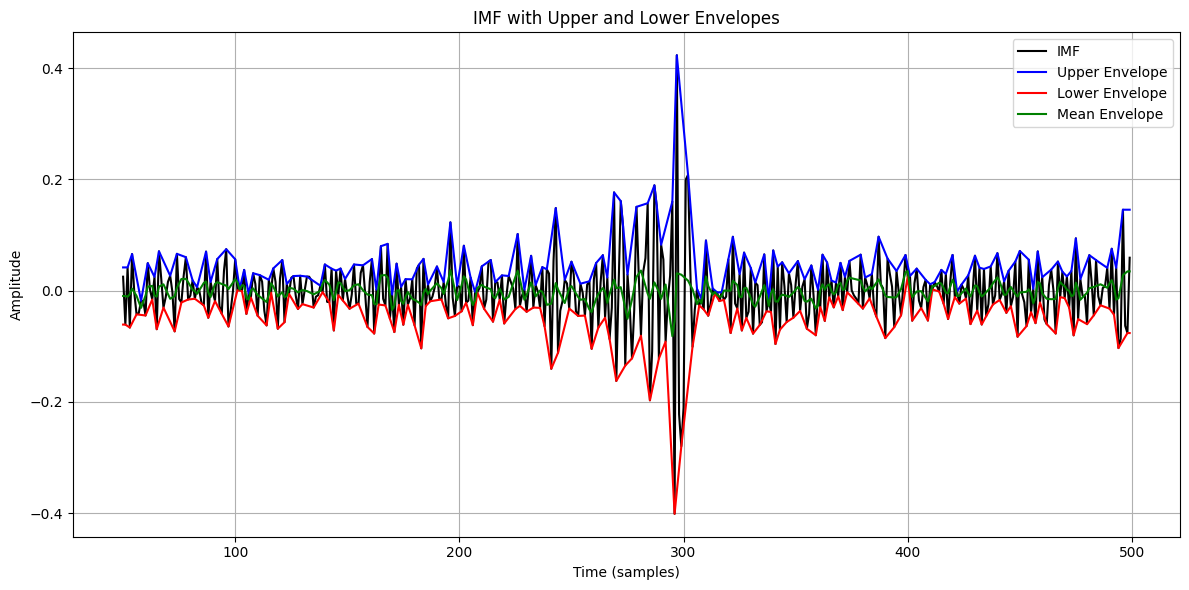

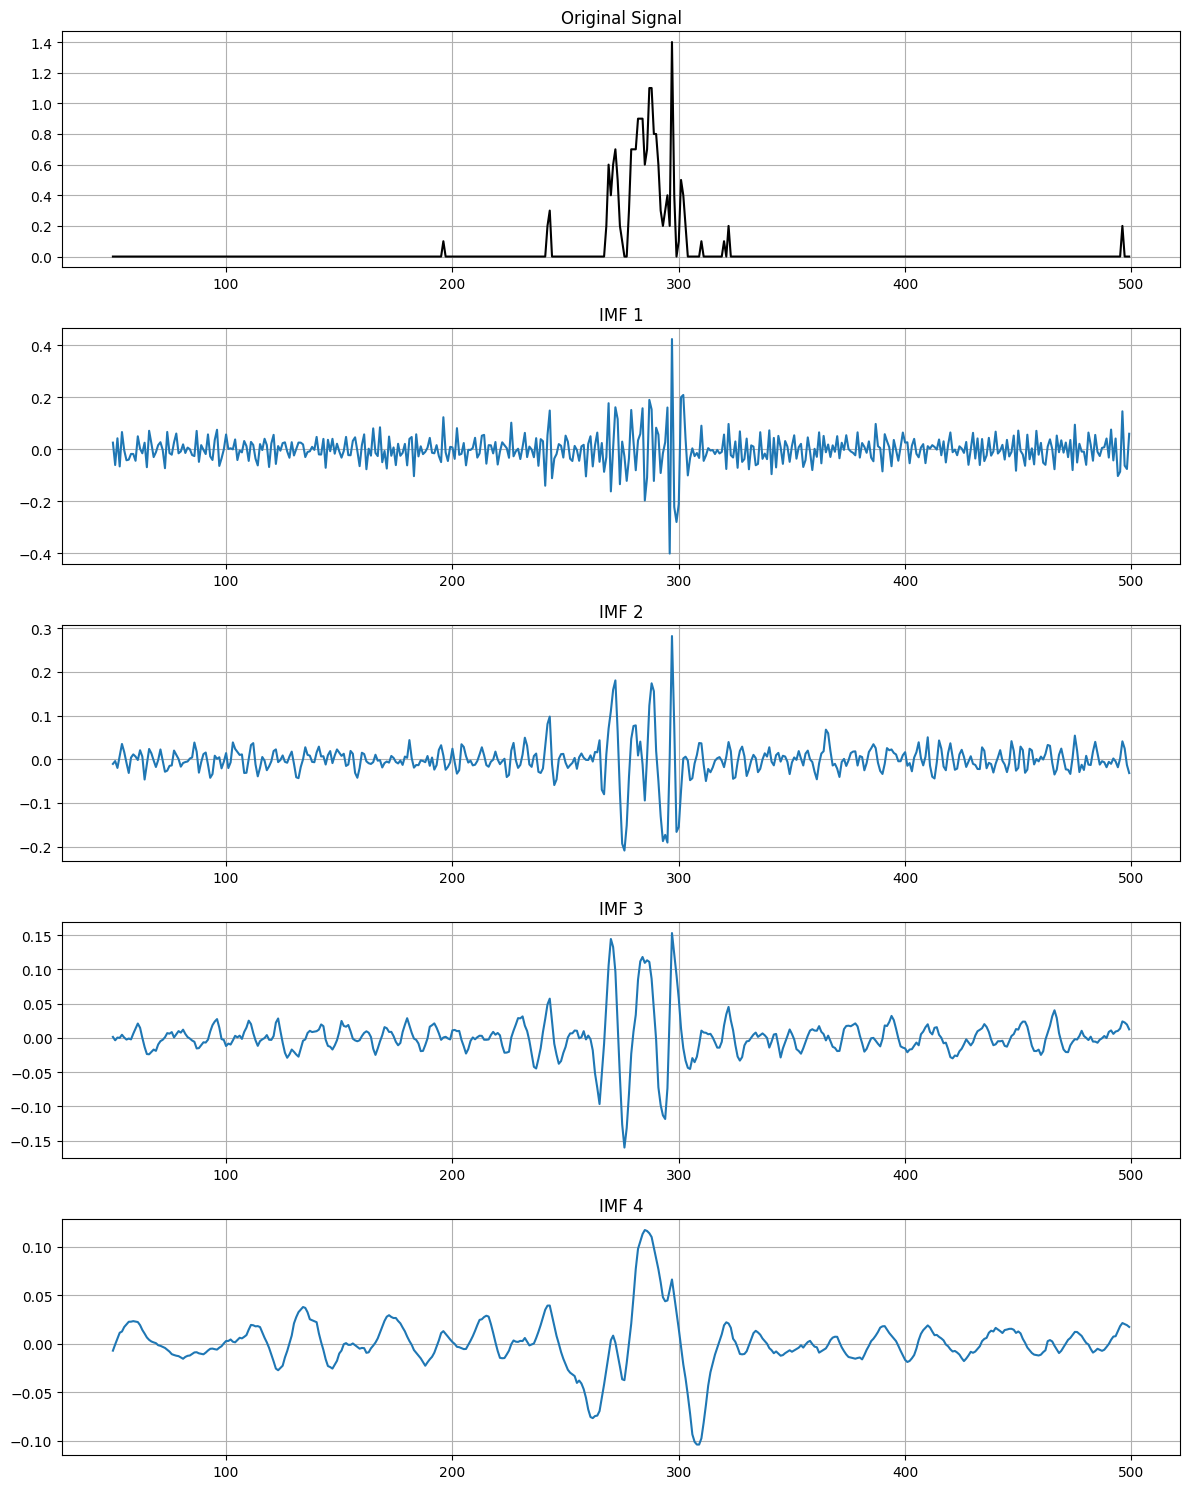

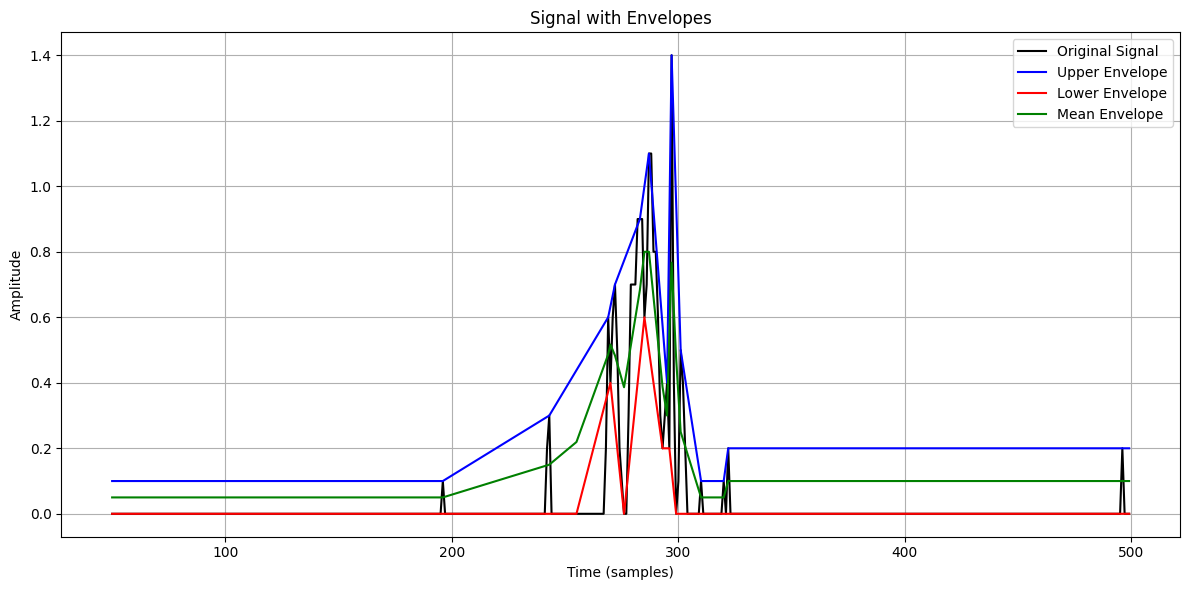

Epoch 1/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - loss: 0.7565 - mae: 0.5474 - mse: 0.7060 - val_loss: 0.0577 - val_mae: 0.0590 - val_mse: 0.0086 - learning_rate: 0.0010
Epoch 2/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 0.2456 - mae: 0.2128 - mse: 0.1969 - val_loss: 0.0547 - val_mae: 0.0440 - val_mse: 0.0069 - learning_rate: 0.0010
Epoch 3/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 0.1815 - mae: 0.1500 - mse: 0.1342 - val_loss: 0.0506 - val_mae: 0.0224 - val_mse: 0.0042 - learning_rate: 0.0010
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Training Results Summary:
       Training Predictions  Actual Values
count          16000.000000   16000.000000
mean               0.110377       0.150594
std                0.377105       0.658184
min               -0.063436       0.000000
25%               -0.017325       0.000000
50%               -0.004358       0.000000
75%                0.082112       0.000000
max               

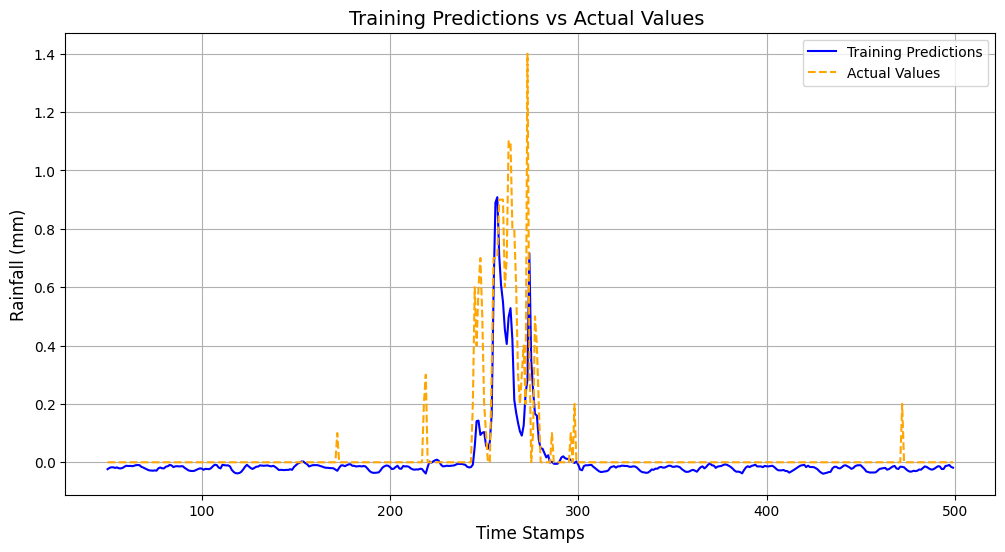

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Validation Results Summary:
       Validation Predictions  Actual Values
count             2000.000000    2000.000000
mean                -0.002493       0.015750
std                  0.063735       0.107111
min                 -0.035225       0.000000
25%                 -0.014843       0.000000
50%                 -0.010164       0.000000
75%                 -0.005770       0.000000
max                  0.951297       1.800000
First 10 rows:
   Validation Predictions  Actual Values
0               -0.026352            0.0
1               -0.027209            0.0
2               -0.018368            0.0
3               -0.007622            0.0
4               -0.005008            0.0
5               -0.009155            0.0
6               -0.006997            0.0
7               -0.006065            0.0
8               -0.004213            0.0
9               -0.000360            0.0


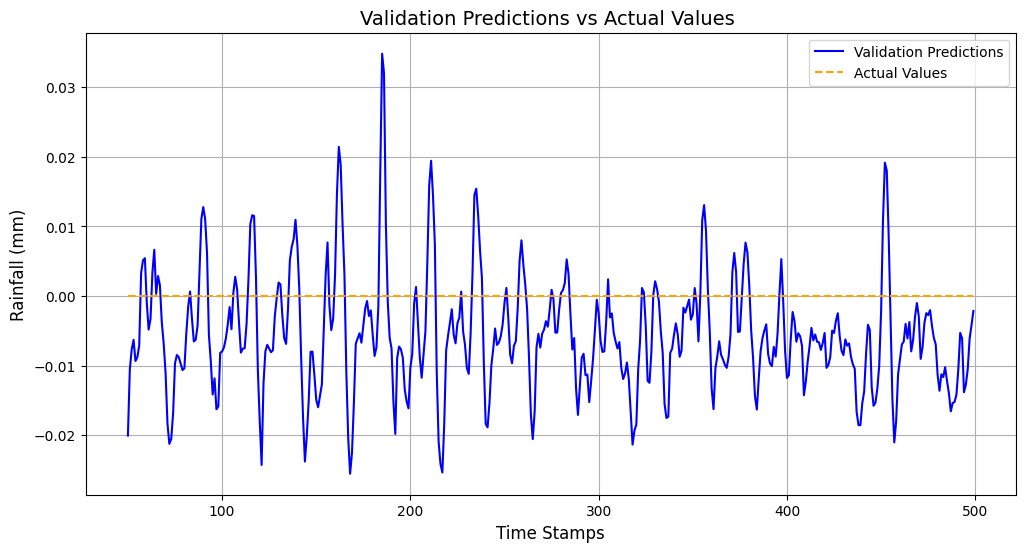

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test Results Summary:
       Test Predictions  Actual Values
count       2000.000000    2000.000000
mean           0.033892       0.080900
std            0.238956       0.407048
min           -0.071913       0.000000
25%           -0.025962       0.000000
50%           -0.016288       0.000000
75%           -0.005621       0.000000
max            3.327286       5.600000
First 10 rows:
   Test Predictions  Actual Values
0         -0.037504            0.0
1         -0.037772            0.0
2         -0.036999            0.0
3         -0.034659            0.0
4         -0.019940            0.0
5         -0.017023            0.0
6         -0.017786            0.0
7         -0.018488            0.0
8         -0.019886            0.0
9         -0.018404            0.0


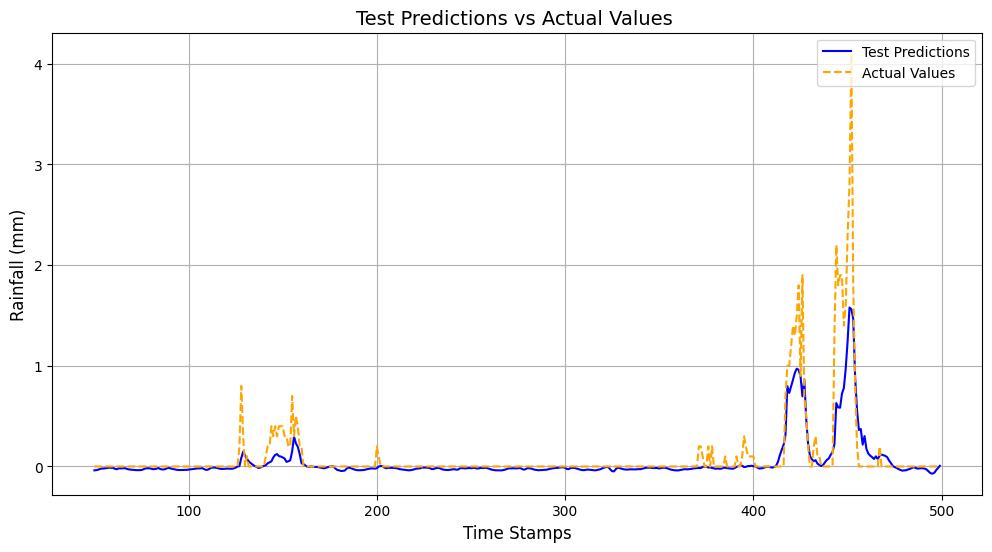


Model Evaluation Results:
mse: 0.0583
mae: 0.0698
false_negative_rate: 0.3671


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import signal

def emd_decomposition(data, num_ensembles=10, noise_amplitude=0.2):
    """
    Perform Ensemble Empirical Mode Decomposition (EEMD) with reduced complexity
    
    Parameters:
    - data: Input time series data
    - num_ensembles: Number of ensemble iterations
    - noise_amplitude: Amplitude of added white noise
    
    Returns:
    - IMFs: List of Intrinsic Mode Functions
    - residue: Residual component
    """
    # Ensure input is a numpy array
    data = np.array(data)
    
    # Limit the number of IMFs and reduce ensemble complexity
    max_imfs = 5
    
    # Initialize ensemble IMFs
    ensemble_imfs = []
    
    # Perform ensemble iterations
    for _ in range(num_ensembles):
        # Add white noise
        noisy_data = data + np.random.normal(0, noise_amplitude * np.std(data), data.shape)
        
        # Decompose noisy signal
        imfs = []
        remaining = noisy_data.copy()
        
        while len(imfs) < max_imfs:
            # Extract IMF
            imf = sift_imf(remaining)
            
            # If IMF is too small, stop
            if len(imf) == 0 or np.all(np.abs(imf) < 1e-8):
                break
            
            imfs.append(imf)
            
            # Remove extracted IMF from remaining signal
            remaining -= imf
        
        # Accumulate IMFs
        if len(ensemble_imfs) == 0:
            ensemble_imfs = imfs
        else:
            # Ensure we have enough IMFs in the accumulator
            while len(ensemble_imfs) < len(imfs):
                ensemble_imfs.append(np.zeros_like(imfs[0]))
            
            # Accumulate IMFs
            for i in range(len(imfs)):
                ensemble_imfs[i] += imfs[i]
    
    # Average the IMFs
    ensemble_imfs = [imf / num_ensembles for imf in ensemble_imfs[:max_imfs]]
    
    # Last IMF is considered the residue
    residue = ensemble_imfs[-1] if ensemble_imfs else np.zeros_like(data)
    ensemble_imfs = ensemble_imfs[:-1] if ensemble_imfs else []
    
    return ensemble_imfs, residue

def sift_imf(data, max_iterations=5):
    """
    Sift out an Intrinsic Mode Function (IMF)
    
    Parameters:
    - data: Input data
    - max_iterations: Maximum sifting iterations
    
    Returns:
    - Extracted IMF
    """
    imf = data.copy()
    
    for _ in range(max_iterations):
        # Find local maxima and minima
        max_indices = signal.find_peaks(imf)[0]
        min_indices = signal.find_peaks(-imf)[0]
        
        # If not enough extrema, consider it an IMF
        if len(max_indices) < 2 or len(min_indices) < 2:
            break
        
        # Interpolate envelopes
        try:
            upper_envelope = np.interp(
                np.arange(len(imf)), 
                max_indices, 
                imf[max_indices]
            )
            lower_envelope = np.interp(
                np.arange(len(imf)), 
                min_indices, 
                imf[min_indices]
            )
        except Exception:
            break
        
        # Calculate mean envelope
        mean_envelope = (upper_envelope + lower_envelope) / 2
        
        # Update IMF
        new_imf = imf - mean_envelope
        
        # Check stopping criterion
        if np.allclose(imf, new_imf, rtol=1e-8, atol=1e-8):
            break
        
        imf = new_imf
    
    return imf

def plot_imfs(imfs, residue, save_path='../artifacts/eemd_decomposition.png'):
    """
    Plot Intrinsic Mode Functions (IMFs) and Residue with size limits
    
    Parameters:
    - imfs: List of Intrinsic Mode Functions
    - residue: Residual component
    - save_path: Path to save the plot
    """
    try:
        # Limit the number of IMFs to plot
        max_imfs_to_plot = 5
        imfs_to_plot = imfs[:max_imfs_to_plot]
        
        # Determine plot size
        num_plots = min(len(imfs_to_plot) + 1, max_imfs_to_plot + 1)
        
        # Adjust figure size to prevent oversized plots
        plt.figure(figsize=(12, 3 * num_plots))
        
        # Plot each IMF
        for i, imf in enumerate(imfs_to_plot, 1):
            plt.subplot(num_plots, 1, i)
            plt.plot(imf[:5000])  # Limit data points to prevent oversized plot
            plt.title(f'IMF {i}')
            plt.tight_layout()
        
        # Plot residue
        plt.subplot(num_plots, 1, num_plots)
        plt.plot(residue[:5000])  # Limit data points
        plt.title('Residue')
        plt.tight_layout()
        
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error in plot_imfs: {e}")
        # Fallback to not plotting if there's an issue
        pass

def plot_imf_with_envelopes(data, zoom_range=(50, 500), save_path='../artifacts/imf_envelopes.png'):
    """
    Plot IMF with upper and lower envelopes plus mean envelope in zoomed range
    
    Parameters:
    - data: Original time series data
    - zoom_range: Range of indices to visualize
    - save_path: Path to save the plot
    """
    try:
        # Extract data segment
        start, end = zoom_range
        segment = data[start:end]
        indices = np.arange(start, end)
        
        # Find envelopes
        max_indices = signal.find_peaks(segment)[0]
        min_indices = signal.find_peaks(-segment)[0]
        
        if len(max_indices) < 2 or len(min_indices) < 2:
            print("Not enough extrema to calculate envelopes")
            return
        
        # Interpolate envelopes
        upper_envelope = np.interp(
            np.arange(len(segment)), 
            max_indices, 
            segment[max_indices]
        )
        lower_envelope = np.interp(
            np.arange(len(segment)), 
            min_indices, 
            segment[min_indices]
        )
        mean_envelope = (upper_envelope + lower_envelope) / 2
        
        # Create plot
        plt.figure(figsize=(12, 6))
        plt.plot(indices, segment, 'k-', label='IMF')
        plt.plot(indices, upper_envelope, 'b-', label='Upper Envelope')
        plt.plot(indices, lower_envelope, 'r-', label='Lower Envelope')
        plt.plot(indices, mean_envelope, 'g-', label='Mean Envelope')
        
        plt.title('IMF with Upper and Lower Envelopes')
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error in plot_imf_with_envelopes: {e}")

def plot_multiple_imfs(imfs, original_data=None, zoom_range=(50, 500), save_path='../artifacts/multiple_imfs.png'):
    """
    Plot multiple IMFs and the original signal in a zoomed range
    
    Parameters:
    - imfs: List of IMFs
    - original_data: Original time series data (optional)
    - zoom_range: Range of indices to visualize
    - save_path: Path to save the plot
    """
    try:
        start, end = zoom_range
        num_plots = len(imfs) + (1 if original_data is not None else 0)
        
        plt.figure(figsize=(12, 3 * num_plots))
        
        # Plot original data if provided
        plot_index = 1
        if original_data is not None:
            plt.subplot(num_plots, 1, plot_index)
            plt.plot(np.arange(start, end), original_data[start:end], 'k-')
            plt.title('Original Signal')
            plt.grid(True)
            plot_index += 1
        
        # Plot each IMF
        for i, imf in enumerate(imfs):
            plt.subplot(num_plots, 1, plot_index)
            plt.plot(np.arange(start, end), imf[start:end])
            plt.title(f'IMF {i+1}')
            plt.grid(True)
            plot_index += 1
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error in plot_multiple_imfs: {e}")

def plot_signal_with_envelopes(data, zoom_range=(50, 500), save_path='../artifacts/signal_envelopes.png'):
    """
    Plot original signal with upper and lower envelopes
    
    Parameters:
    - data: Original time series data
    - zoom_range: Range of indices to visualize
    - save_path: Path to save the plot
    """
    try:
        # Extract data segment
        start, end = zoom_range
        segment = data[start:end]
        indices = np.arange(start, end)
        
        # Find local maxima and minima
        max_indices = signal.find_peaks(segment)[0]
        min_indices = signal.find_peaks(-segment)[0]
        
        if len(max_indices) < 2 or len(min_indices) < 2:
            print("Not enough extrema to calculate envelopes")
            return
        
        # Interpolate envelopes
        upper_envelope = np.interp(
            np.arange(len(segment)), 
            max_indices, 
            segment[max_indices]
        )
        lower_envelope = np.interp(
            np.arange(len(segment)), 
            min_indices, 
            segment[min_indices]
        )
        mean_envelope = (upper_envelope + lower_envelope) / 2
        
        # Create plot
        plt.figure(figsize=(12, 6))
        plt.plot(indices, segment, 'k-', label='Original Signal')
        plt.plot(indices, upper_envelope, 'b-', label='Upper Envelope')
        plt.plot(indices, lower_envelope, 'r-', label='Lower Envelope')
        plt.plot(indices, mean_envelope, 'g-', label='Mean Envelope')
        
        plt.title('Signal with Envelopes')
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error in plot_signal_with_envelopes: {e}")

def plot_predictions(model, X_data, y_data, label, start=50, end=500, 
                    ylabel='Rainfall (mm)', title_suffix='', 
                    save_path=None):
    """
    Plots predictions vs actual values for a given model and dataset.
    
    Args:
    - model: The trained model to use for predictions.
    - X_data: Input data for predictions.
    - y_data: Actual target values.
    - label: A string indicating the dataset (e.g., 'Train', 'Validation', 'Test').
    - start, end: Range of data points to visualize (default: 50 to 500).
    - ylabel: Label for the y-axis (default: 'Rainfall (mm)').
    - title_suffix: Additional suffix for the title (optional).
    - save_path: Path to save the plot (optional).
    
    Returns:
    - A DataFrame containing the predictions and actual values.
    """
    # Make predictions
    predictions = model.predict(X_data).flatten()

    # Create a DataFrame to store results
    results_df = pd.DataFrame(data={f'{label} Predictions': predictions, 'Actual Values': y_data})
    
    # Limit output to avoid large printouts
    print(f"{label} Results Summary:")
    print(results_df.describe())
    print(f"First 10 rows:\n{results_df.head(10)}")

    # Plot the predictions and actual values
    plt.figure(figsize=(12, 6))
    plt.plot(results_df[f'{label} Predictions'][start:end], label=f'{label} Predictions', 
             color='blue', linestyle='-')
    plt.plot(results_df['Actual Values'][start:end], label='Actual Values', 
             color='orange', linestyle='--')

    # Add labels and title
    plt.xlabel('Time Stamps', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(f'{label} Predictions vs Actual Values {title_suffix}', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # Save the plot if a path is specified
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

    return results_df

def preprocess_data(df, max_features=50):
    """
    Modified preprocessing to incorporate EEMD with memory efficiency
    
    Parameters:
    - df: Input DataFrame
    - max_features: Maximum number of features to retain
    
    Returns:
    - Preprocessed DataFrame with EEMD features
    - Original data
    - List of IMFs
    - Residue
    """
    # Store original data
    original_data = df.iloc[:, 0].values
    
    # Perform EEMD on the first column (target variable)
    imfs, residue = emd_decomposition(original_data)
    
    # Plot IMFs
    plot_imfs(imfs, residue)
    
    # Plot IMF with envelopes (for the first IMF)
    if imfs:
        plot_imf_with_envelopes(imfs[0])
    
    # Plot multiple IMFs
    plot_multiple_imfs(imfs, original_data)
    
    # Plot signal with envelopes
    plot_signal_with_envelopes(original_data)
    
    # Create IMF features efficiently
    imf_features = []
    
    # Add IMFs as new features
    for i, imf in enumerate(imfs, 1):
        col_name = f'IMF_{i}'
        imf_features.append(pd.Series(imf[:len(df)], name=col_name, index=df.index))
    
    # Add residue
    imf_features.append(pd.Series(residue[:len(df)], name='Residue', index=df.index))
    
    # Combine IMF features efficiently
    imf_df = pd.concat(imf_features, axis=1)
    
    # Combine original features with IMFs
    processed_df = pd.concat([df, imf_df], axis=1)
    
    # Add cyclical time features
    processed_df['Seconds'] = processed_df.index.map(pd.Timestamp.timestamp)
    
    day = 24 * 60 * 60
    year = (365.2425) * day
    
    processed_df['Day_sin'] = np.sin(processed_df['Seconds'] * (2 * np.pi / day))
    processed_df['Day_cos'] = np.cos(processed_df['Seconds'] * (2 * np.pi / day))
    processed_df['Year_sin'] = np.sin(processed_df['Seconds'] * (2 * np.pi / year))
    processed_df['Year_cos'] = np.cos(processed_df['Seconds'] * (2 * np.pi / year))
    
    # Add rolling statistics
    first_col = processed_df.columns[0]
    processed_df['rolling_mean_6h'] = processed_df[first_col].rolling(window=6).mean()
    processed_df['rolling_std_6h'] = processed_df[first_col].rolling(window=6).std()
    processed_df['rolling_max_6h'] = processed_df[first_col].rolling(window=6).max()
    
    # Add lag features for IMFs with memory efficiency
    lag_features = []
    for i in range(1, len(imfs) + 1):
        for lag in [1, 3, 6, 12]:
            col_name = f'IMF_{i}_lag_{lag}'
            lag_features.append(
                pd.Series(
                    processed_df[f'IMF_{i}'].shift(lag), 
                    name=col_name, 
                    index=processed_df.index
                )
            )
    
    # Combine lag features efficiently
    if lag_features:
        lag_df = pd.concat(lag_features, axis=1)
        processed_df = pd.concat([processed_df, lag_df], axis=1)
    
    # Drop unnecessary columns and handle memory
    processed_df = processed_df.drop(['Seconds'], axis=1)
    processed_df = processed_df.bfill()
    
    # Limit the number of features
    feature_columns = processed_df.columns[:max_features]
    processed_df = processed_df[feature_columns]
    
    return processed_df, original_data, imfs, residue

def df_to_X_y(df, window_size=24, max_samples=None):
    """
    Convert DataFrame to sequences with memory-efficient approach
    """
    try:
        df_as_np = df.to_numpy()
        X, y = [], []
        
        # Limit the number of samples to prevent memory overflow
        max_iterations = len(df_as_np) - window_size
        if max_samples:
            max_iterations = min(max_iterations, max_samples)
        
        for i in range(max_iterations):
            row = [r for r in df_as_np[i: i + window_size]]
            X.append(row)
            label = df_as_np[i + window_size][0]
            y.append(label)
        
        return np.array(X), np.array(y)
    except Exception as e:
        print(f"Error in df_to_X_y: {e}")
        raise

def split_time_series_data(X, y, train_ratio=0.8, val_ratio=0.1):
    """
    Split time series data with memory efficiency
    """
    try:
        n = len(X)
        train_end = int(n * train_ratio)
        val_end = train_end + int(n * val_ratio)

        X_train, y_train = X[:train_end], y[:train_end]
        X_val, y_val = X[train_end:val_end], y[train_end:val_end]
        X_test, y_test = X[val_end:], y[val_end:]

        return X_train, X_val, X_test, y_train, y_val, y_test
    except Exception as e:
        print(f"Error in split_time_series_data: {e}")
        raise

def create_gru_model(input_shape, dropout_rate=0.3):
    """
    Create a memory-efficient GRU model
    """
    try:
        model = Sequential([
            InputLayer(shape=input_shape),
            
            GRU(
                128,
                return_sequences=True,
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)
            ),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            GRU(
                64,
                return_sequences=False,
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)
            ),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            Dense(
                32,
                activation='relu',
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)
            ),
            Dropout(dropout_rate),
            
            Dense(1, activation='linear')
        ])
        return model
    except Exception as e:
        print(f"Error in create_gru_model: {e}")
        raise

def train_model(model, X_train, y_train, X_val, y_val, model_path, 
                batch_size=16, epochs=3, patience=10):
    """
    Train model with reduced complexity and memory usage
    """
    try:
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True),
            ModelCheckpoint(model_path, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        ]
        
        model.compile(
            optimizer=Adam(learning_rate=1e-3),
            loss='mse',
            metrics=['mse', 'mae']
        )
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )
        return history
    except Exception as e:
        print(f"Error in train_model: {e}")
        raise

def evaluate_model(model, X_test, y_test, threshold=0.5):
    """
    Evaluate model performance
    """
    try:
        predictions = model.predict(X_test)
        
        # Calculate various metrics
        mse = np.mean((y_test - predictions.flatten())**2)
        mae = np.mean(np.abs(y_test - predictions.flatten()))
        
        # Calculate false negative rate
        binary_actual = y_test > threshold
        binary_pred = predictions.flatten() > threshold
        false_negatives = np.sum((binary_actual == True) & (binary_pred == False))
        false_negative_rate = false_negatives / np.sum(binary_actual) if np.sum(binary_actual) > 0 else 0
        
        return {
            'mse': mse,
            'mae': mae,
            'false_negative_rate': false_negative_rate
        }
    except Exception as e:
        print(f"Error in evaluate_model: {e}")
        raise

def main():
    try:
        # Load and preprocess data
        df = pd.read_csv('../artifacts/dataset/01-hourly_historical_analyzed_data.csv')
        df = df.drop(columns=['hour', 'day', 'month', 'year'])
        
        # Convert to datetime index
        df1 = df.copy()
        df1.index = pd.to_datetime(df1['time'], format='%Y-%m-%d %H:%M:%S')
        
        # Extract rain data
        rain = df1['rain']
        rain_df = pd.DataFrame(rain)
        
        # Preprocess data with EEMD
        processed_df, original_data, imfs, residue = preprocess_data(rain_df, max_features=50)
        
        # Create sequences with limited samples to manage memory
        X, y = df_to_X_y(processed_df, window_size=24, max_samples=20000)
        
        # Split data
        X_train, X_val, X_test, y_train, y_val, y_test = split_time_series_data(X, y)
        
        # Scale the data
        scaler = StandardScaler()
        X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
        scaler.fit(X_train_reshaped)
        
        def scale_data(X):
            orig_shape = X.shape
            X_reshaped = X.reshape(-1, X.shape[-1])
            X_scaled = scaler.transform(X_reshaped)
            return X_scaled.reshape(orig_shape)
        
        X_train = scale_data(X_train)
        X_val = scale_data(X_val)
        X_test = scale_data(X_test)
        
        # Create GRU model
        model = create_gru_model(input_shape=(X_train.shape[1], X_train.shape[2]))
        
        # Train model
        history = train_model(
            model, X_train, y_train, X_val, y_val, 
            '../artifacts/models/eemd_gru_model.keras'
        )
        
        # Evaluate model
        results = evaluate_model(model, X_test, y_test)
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('GRU Model Training History with EEMD')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig('../artifacts/eemd_gru_training_history.png')
        plt.close()
        
        # Plot predictions
        plot_predictions(model, X_train, y_train, 'Training', 
                         start=50, end=500, 
                         save_path='../artifacts/training_predictions.png')
        
        plot_predictions(model, X_val, y_val, 'Validation', 
                         start=50, end=500, 
                         save_path='../artifacts/validation_predictions.png')
        
        plot_predictions(model, X_test, y_test, 'Test', 
                         start=50, end=500, 
                         save_path='../artifacts/test_predictions.png')
        
        return results
    
    except Exception as e:
        print(f"Error in main: {e}")
        raise

if __name__ == "__main__":
    try:
        results = main()
        print("\nModel Evaluation Results:")
        for metric_name, value in results.items():
            print(f"{metric_name}: {value:.4f}")
    except Exception as e:
        print(f"Unhandled error in execution: {e}")

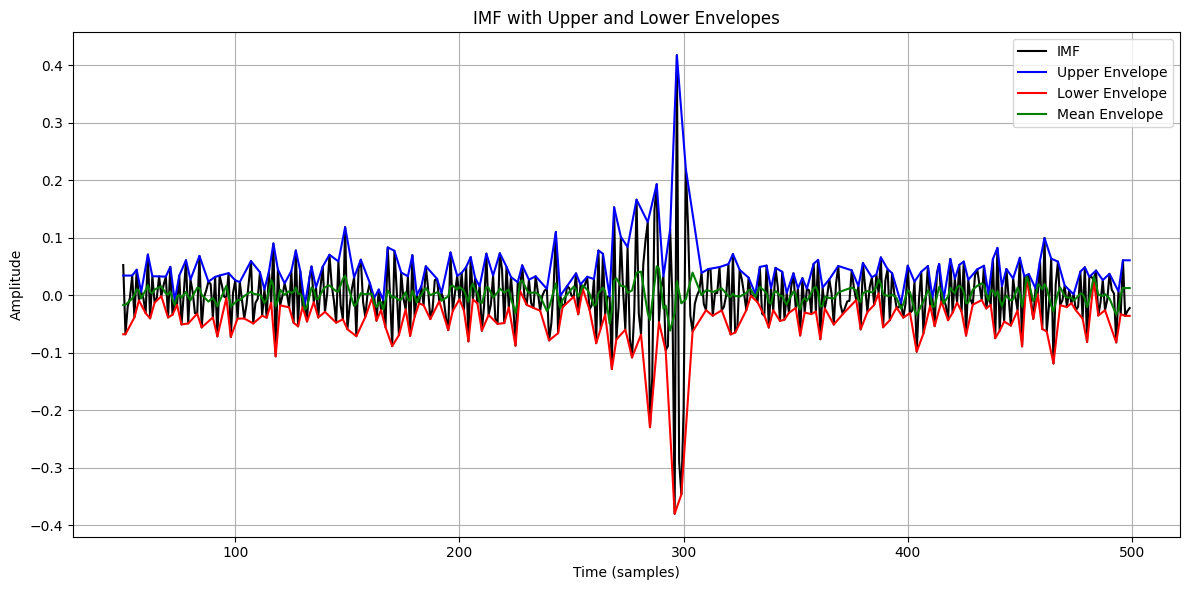

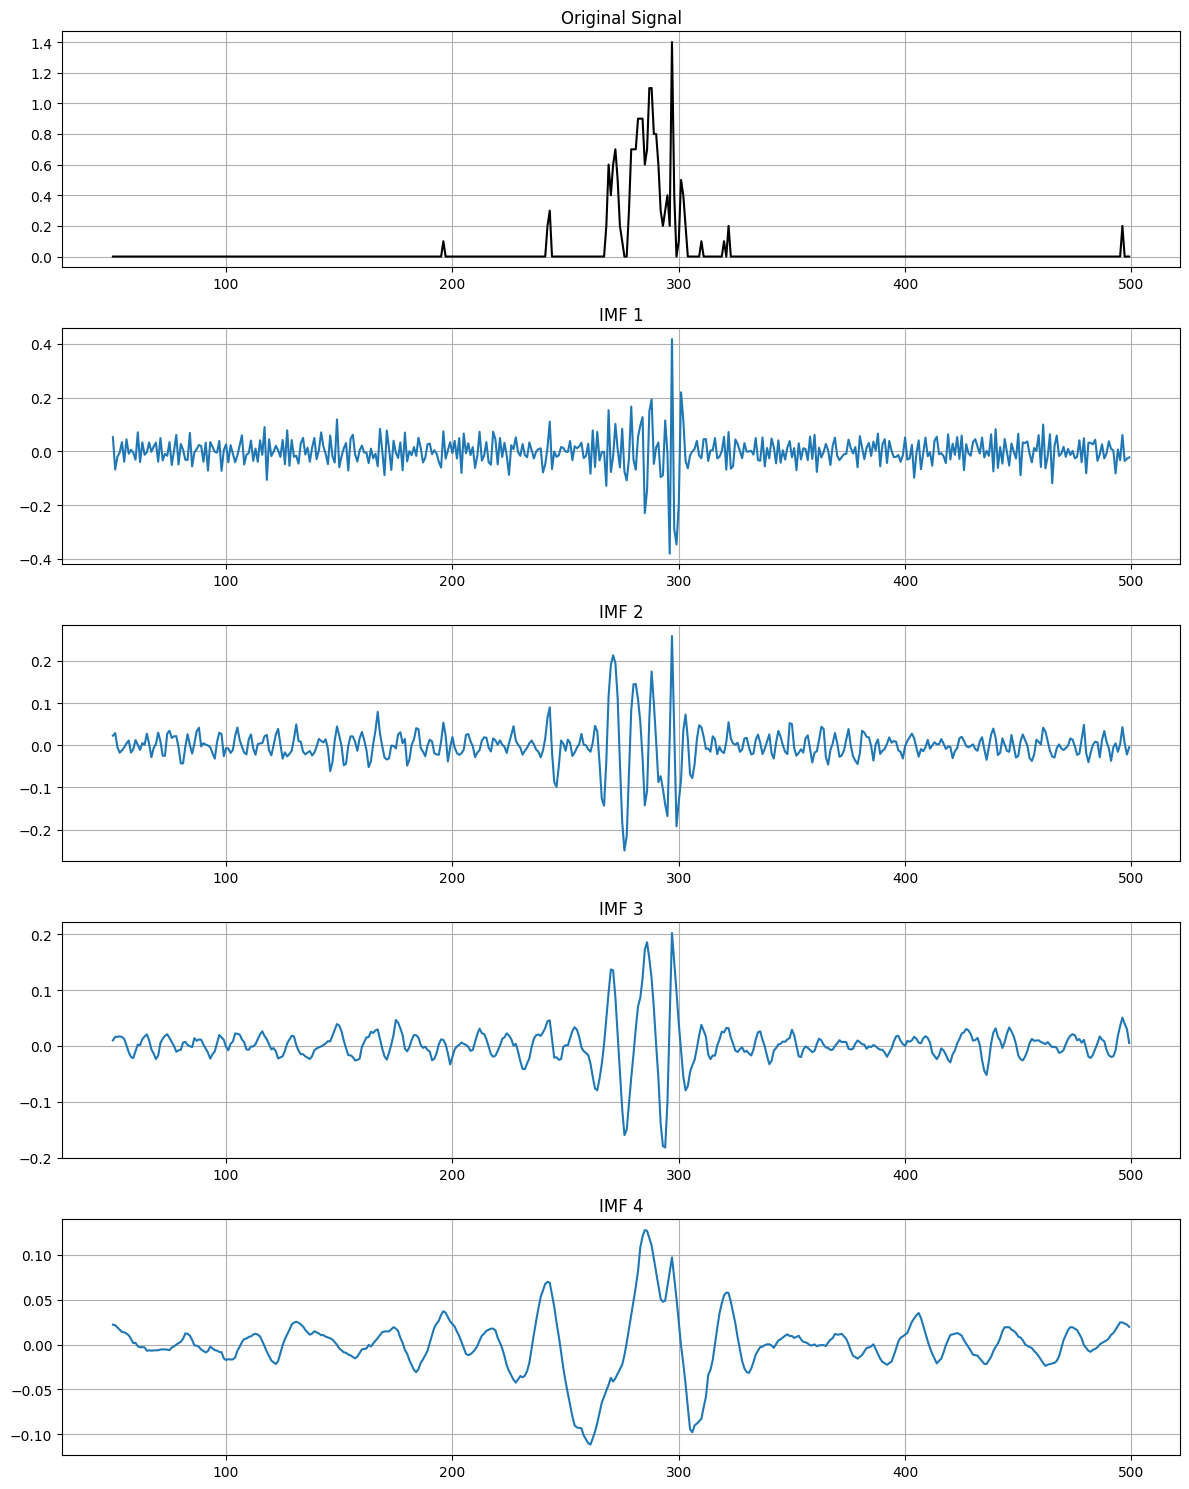

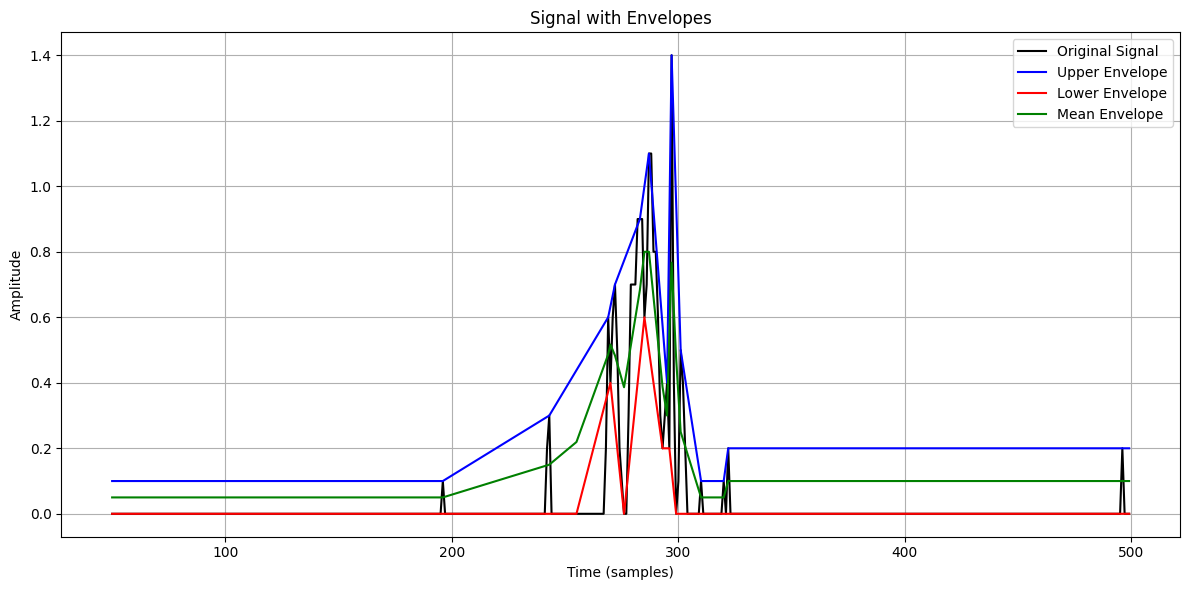

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - loss: 0.9325 - mae: 0.6255 - mse: 0.8812 - val_loss: 0.0640 - val_mae: 0.0755 - val_mse: 0.0136 - learning_rate: 0.0010
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - loss: 0.2733 - mae: 0.2221 - mse: 0.2234 - val_loss: 0.0568 - val_mae: 0.0281 - val_mse: 0.0081 - learning_rate: 0.0010
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.2012 - mae: 0.1645 - mse: 0.1530 - val_loss: 0.0526 - val_mae: 0.0284 - val_mse: 0.0053 - learning_rate: 0.0010
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.1773 - mae: 0.1491 - mse: 0.1303 - val_loss: 0.0497 - val_mae: 0.0239 - val_mse: 0.0033 - learning_rate: 0.0010
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.1876 - mae: 0.1339 - mse: 0.1413 - val_loss: 0.0519 - val_mae: 0.0255 - val_mse: 0.0059 - learning_rate: 0.0010
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 0.2291 - mae: 0.1458 - mse: 0.1828 - val_loss:

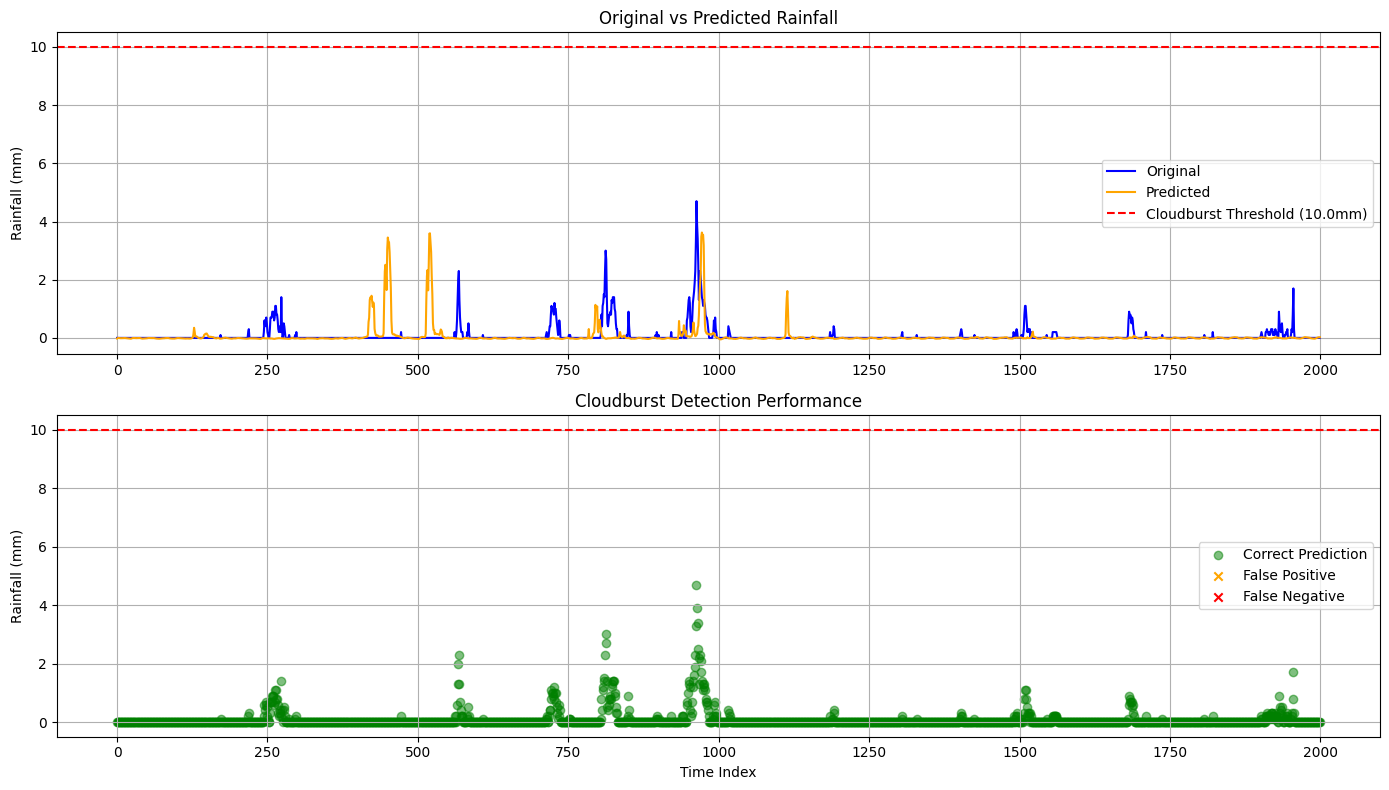

Total actual cloudbursts: 0
Correctly detected cloudbursts: 0 (nan% detection rate)
False alarms: 0
Missed cloudbursts: 0
Completed analysis and saved comparison results


C:\Users\Hp\AppData\Local\Temp\ipykernel_15924\1665370121.py:689: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Correctly detected cloudbursts: {detected_cloudbursts} ({detected_cloudbursts/total_cloudbursts*100:.2f}% detection rate)")


500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Training Results Summary:
       Training Predictions  Actual Values
count          16000.000000   16000.000000
mean               0.117585       0.150594
std                0.458486       0.658184
min               -0.048963       0.000000
25%               -0.007303       0.000000
50%                0.012812       0.000000
75%                0.046350       0.000000
max                8.831285      19.000000
First 10 rows:
   Training Predictions  Actual Values
0              0.002020            0.0
1              0.003049            0.0
2              0.006442            0.0
3              0.005047            0.0
4             -0.000432            0.0
5             -0.000502            0.0
6             -0.002842            0.0
7             -0.001566            0.0
8              0.000848            0.0
9              0.005228            0.0


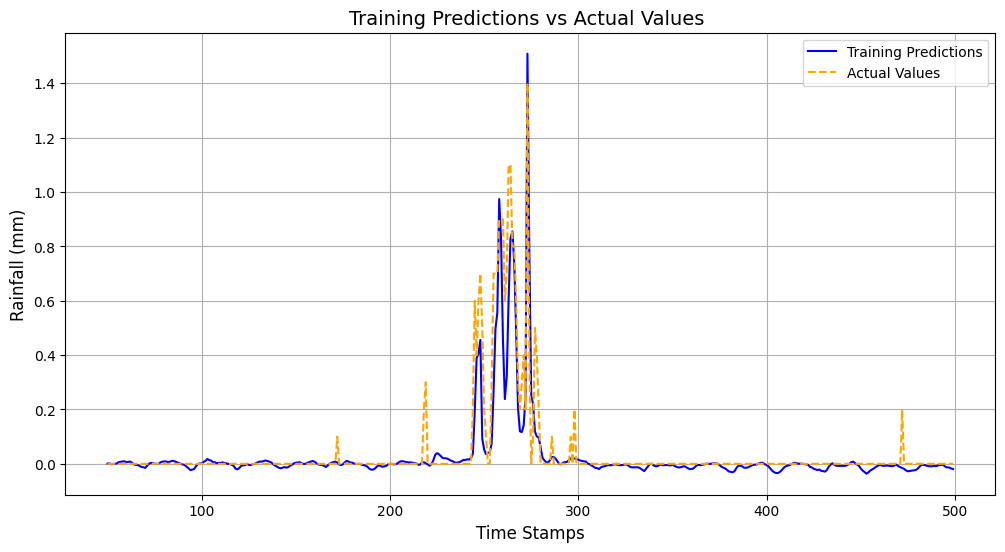

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Validation Results Summary:
       Validation Predictions  Actual Values
count             2000.000000    2000.000000
mean                 0.014687       0.015750
std                  0.083775       0.107111
min                 -0.029620       0.000000
25%                 -0.001950       0.000000
50%                  0.007085       0.000000
75%                  0.015481       0.000000
max                  1.481027       1.800000
First 10 rows:
   Validation Predictions  Actual Values
0                0.002759            0.0
1               -0.000746            0.0
2               -0.001279            0.0
3               -0.006141            0.0
4               -0.013292            0.0
5               -0.014767            0.0
6               -0.013048            0.0
7               -0.004486            0.0
8                0.000224            0.0
9               -0.001205            0.0


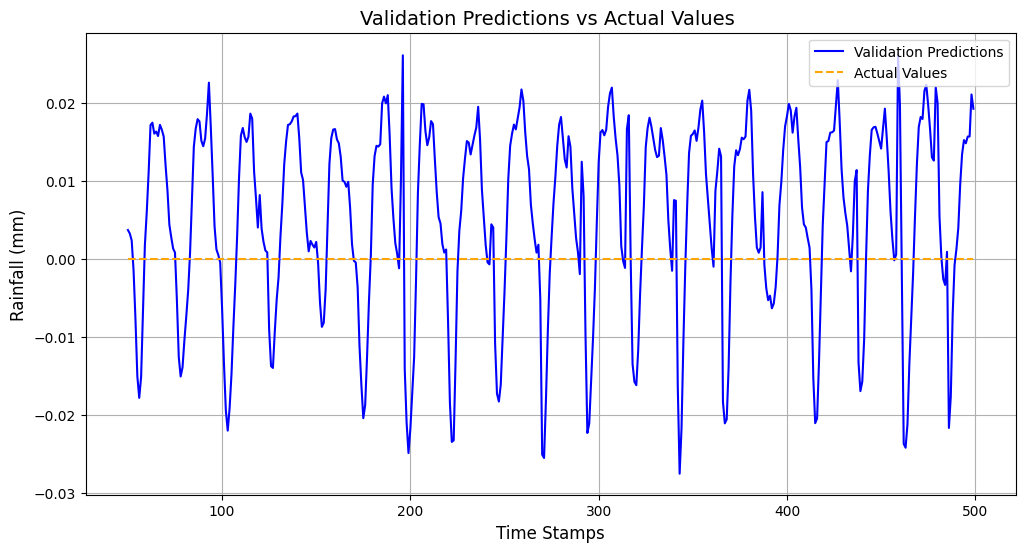

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Test Results Summary:
       Test Predictions  Actual Values
count       2000.000000    2000.000000
mean           0.053404       0.080900
std            0.355092       0.407048
min           -0.050991       0.000000
25%           -0.021114       0.000000
50%           -0.010571       0.000000
75%            0.005603       0.000000
max            3.621308       5.600000
First 10 rows:
   Test Predictions  Actual Values
0         -0.022262            0.0
1         -0.007407            0.0
2         -0.001513            0.0
3         -0.004782            0.0
4         -0.006137            0.0
5         -0.009546            0.0
6         -0.010755            0.0
7         -0.011573            0.0
8         -0.009924            0.0
9         -0.008116            0.0


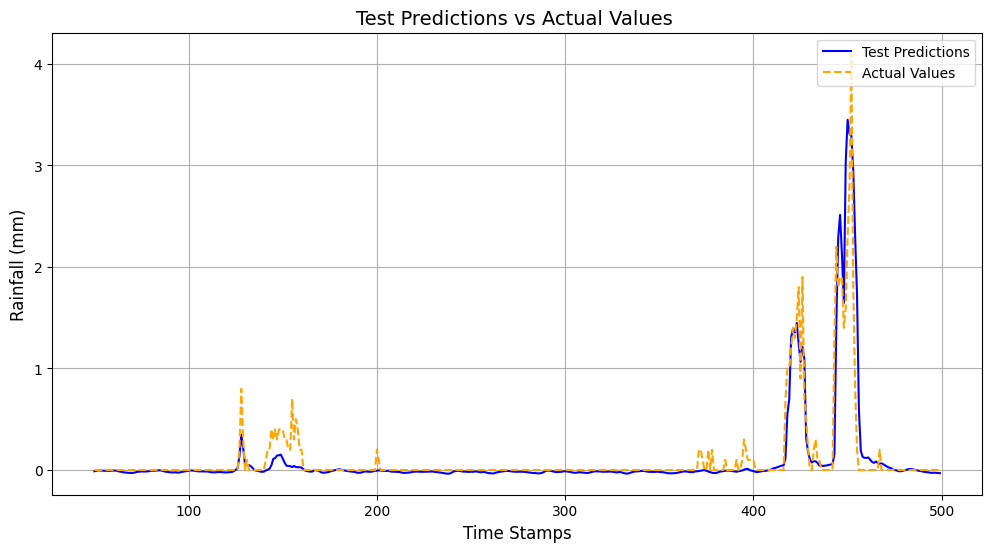


Model Evaluation Results:
mse: 0.0281
mae: 0.0562
false_negative_rate: 0.3544

Demonstrating prediction on new data:
Unhandled error in execution: X has 25 features, but StandardScaler is expecting 29 features as input.


C:\Users\Hp\AppData\Local\Temp\ipykernel_15924\1665370121.py:822: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start='2023-01-01', periods=200, freq='H')


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import signal

def emd_decomposition(data, num_ensembles=10, noise_amplitude=0.2):
    """
    Perform Ensemble Empirical Mode Decomposition (EEMD) with reduced complexity
    
    Parameters:
    - data: Input time series data
    - num_ensembles: Number of ensemble iterations
    - noise_amplitude: Amplitude of added white noise
    
    Returns:
    - IMFs: List of Intrinsic Mode Functions
    - residue: Residual component
    """
    # Ensure input is a numpy array
    data = np.array(data)
    
    # Limit the number of IMFs and reduce ensemble complexity
    max_imfs = 5
    
    # Initialize ensemble IMFs
    ensemble_imfs = []
    
    # Perform ensemble iterations
    for _ in range(num_ensembles):
        # Add white noise
        noisy_data = data + np.random.normal(0, noise_amplitude * np.std(data), data.shape)
        
        # Decompose noisy signal
        imfs = []
        remaining = noisy_data.copy()
        
        while len(imfs) < max_imfs:
            # Extract IMF
            imf = sift_imf(remaining)
            
            # If IMF is too small, stop
            if len(imf) == 0 or np.all(np.abs(imf) < 1e-8):
                break
            
            imfs.append(imf)
            
            # Remove extracted IMF from remaining signal
            remaining -= imf
        
        # Accumulate IMFs
        if len(ensemble_imfs) == 0:
            ensemble_imfs = imfs
        else:
            # Ensure we have enough IMFs in the accumulator
            while len(ensemble_imfs) < len(imfs):
                ensemble_imfs.append(np.zeros_like(imfs[0]))
            
            # Accumulate IMFs
            for i in range(len(imfs)):
                ensemble_imfs[i] += imfs[i]
    
    # Average the IMFs
    ensemble_imfs = [imf / num_ensembles for imf in ensemble_imfs[:max_imfs]]
    
    # Last IMF is considered the residue
    residue = ensemble_imfs[-1] if ensemble_imfs else np.zeros_like(data)
    ensemble_imfs = ensemble_imfs[:-1] if ensemble_imfs else []
    
    return ensemble_imfs, residue

def sift_imf(data, max_iterations=5):
    """
    Sift out an Intrinsic Mode Function (IMF)
    
    Parameters:
    - data: Input data
    - max_iterations: Maximum sifting iterations
    
    Returns:
    - Extracted IMF
    """
    imf = data.copy()
    
    for _ in range(max_iterations):
        # Find local maxima and minima
        max_indices = signal.find_peaks(imf)[0]
        min_indices = signal.find_peaks(-imf)[0]
        
        # If not enough extrema, consider it an IMF
        if len(max_indices) < 2 or len(min_indices) < 2:
            break
        
        # Interpolate envelopes
        try:
            upper_envelope = np.interp(
                np.arange(len(imf)), 
                max_indices, 
                imf[max_indices]
            )
            lower_envelope = np.interp(
                np.arange(len(imf)), 
                min_indices, 
                imf[min_indices]
            )
        except Exception:
            break
        
        # Calculate mean envelope
        mean_envelope = (upper_envelope + lower_envelope) / 2
        
        # Update IMF
        new_imf = imf - mean_envelope
        
        # Check stopping criterion
        if np.allclose(imf, new_imf, rtol=1e-8, atol=1e-8):
            break
        
        imf = new_imf
    
    return imf

def plot_imfs(imfs, residue, save_path='../artifacts/eemd_decomposition.png'):
    """
    Plot Intrinsic Mode Functions (IMFs) and Residue with size limits
    
    Parameters:
    - imfs: List of Intrinsic Mode Functions
    - residue: Residual component
    - save_path: Path to save the plot
    """
    try:
        # Limit the number of IMFs to plot
        max_imfs_to_plot = 5
        imfs_to_plot = imfs[:max_imfs_to_plot]
        
        # Determine plot size
        num_plots = min(len(imfs_to_plot) + 1, max_imfs_to_plot + 1)
        
        # Adjust figure size to prevent oversized plots
        plt.figure(figsize=(12, 3 * num_plots))
        
        # Plot each IMF
        for i, imf in enumerate(imfs_to_plot, 1):
            plt.subplot(num_plots, 1, i)
            plt.plot(imf[:5000])  # Limit data points to prevent oversized plot
            plt.title(f'IMF {i}')
            plt.tight_layout()
        
        # Plot residue
        plt.subplot(num_plots, 1, num_plots)
        plt.plot(residue[:5000])  # Limit data points
        plt.title('Residue')
        plt.tight_layout()
        
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Error in plot_imfs: {e}")
        # Fallback to not plotting if there's an issue
        pass

def plot_imf_with_envelopes(data, zoom_range=(50, 500), save_path='../artifacts/imf_envelopes.png'):
    """
    Plot IMF with upper and lower envelopes plus mean envelope in zoomed range
    
    Parameters:
    - data: Original time series data
    - zoom_range: Range of indices to visualize
    - save_path: Path to save the plot
    """
    try:
        # Extract data segment
        start, end = zoom_range
        segment = data[start:end]
        indices = np.arange(start, end)
        
        # Find envelopes
        max_indices = signal.find_peaks(segment)[0]
        min_indices = signal.find_peaks(-segment)[0]
        
        if len(max_indices) < 2 or len(min_indices) < 2:
            print("Not enough extrema to calculate envelopes")
            return
        
        # Interpolate envelopes
        upper_envelope = np.interp(
            np.arange(len(segment)), 
            max_indices, 
            segment[max_indices]
        )
        lower_envelope = np.interp(
            np.arange(len(segment)), 
            min_indices, 
            segment[min_indices]
        )
        mean_envelope = (upper_envelope + lower_envelope) / 2
        
        # Create plot
        plt.figure(figsize=(12, 6))
        plt.plot(indices, segment, 'k-', label='IMF')
        plt.plot(indices, upper_envelope, 'b-', label='Upper Envelope')
        plt.plot(indices, lower_envelope, 'r-', label='Lower Envelope')
        plt.plot(indices, mean_envelope, 'g-', label='Mean Envelope')
        
        plt.title('IMF with Upper and Lower Envelopes')
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error in plot_imf_with_envelopes: {e}")

def plot_multiple_imfs(imfs, original_data=None, zoom_range=(50, 500), save_path='../artifacts/multiple_imfs.png'):
    """
    Plot multiple IMFs and the original signal in a zoomed range
    
    Parameters:
    - imfs: List of IMFs
    - original_data: Original time series data (optional)
    - zoom_range: Range of indices to visualize
    - save_path: Path to save the plot
    """
    try:
        start, end = zoom_range
        num_plots = len(imfs) + (1 if original_data is not None else 0)
        
        plt.figure(figsize=(12, 3 * num_plots))
        
        # Plot original data if provided
        plot_index = 1
        if original_data is not None:
            plt.subplot(num_plots, 1, plot_index)
            plt.plot(np.arange(start, end), original_data[start:end], 'k-')
            plt.title('Original Signal')
            plt.grid(True)
            plot_index += 1
        
        # Plot each IMF
        for i, imf in enumerate(imfs):
            plt.subplot(num_plots, 1, plot_index)
            plt.plot(np.arange(start, end), imf[start:end])
            plt.title(f'IMF {i+1}')
            plt.grid(True)
            plot_index += 1
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error in plot_multiple_imfs: {e}")

def plot_signal_with_envelopes(data, zoom_range=(50, 500), save_path='../artifacts/signal_envelopes.png'):
    """
    Plot original signal with upper and lower envelopes
    
    Parameters:
    - data: Original time series data
    - zoom_range: Range of indices to visualize
    - save_path: Path to save the plot
    """
    try:
        # Extract data segment
        start, end = zoom_range
        segment = data[start:end]
        indices = np.arange(start, end)
        
        # Find local maxima and minima
        max_indices = signal.find_peaks(segment)[0]
        min_indices = signal.find_peaks(-segment)[0]
        
        if len(max_indices) < 2 or len(min_indices) < 2:
            print("Not enough extrema to calculate envelopes")
            return
        
        # Interpolate envelopes
        upper_envelope = np.interp(
            np.arange(len(segment)), 
            max_indices, 
            segment[max_indices]
        )
        lower_envelope = np.interp(
            np.arange(len(segment)), 
            min_indices, 
            segment[min_indices]
        )
        mean_envelope = (upper_envelope + lower_envelope) / 2
        
        # Create plot
        plt.figure(figsize=(12, 6))
        plt.plot(indices, segment, 'k-', label='Original Signal')
        plt.plot(indices, upper_envelope, 'b-', label='Upper Envelope')
        plt.plot(indices, lower_envelope, 'r-', label='Lower Envelope')
        plt.plot(indices, mean_envelope, 'g-', label='Mean Envelope')
        
        plt.title('Signal with Envelopes')
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error in plot_signal_with_envelopes: {e}")

def plot_predictions(model, X_data, y_data, label, start=50, end=500, 
                    ylabel='Rainfall (mm)', title_suffix='', 
                    save_path=None):
    """
    Plots predictions vs actual values for a given model and dataset.
    
    Args:
    - model: The trained model to use for predictions.
    - X_data: Input data for predictions.
    - y_data: Actual target values.
    - label: A string indicating the dataset (e.g., 'Train', 'Validation', 'Test').
    - start, end: Range of data points to visualize (default: 50 to 500).
    - ylabel: Label for the y-axis (default: 'Rainfall (mm)').
    - title_suffix: Additional suffix for the title (optional).
    - save_path: Path to save the plot (optional).
    
    Returns:
    - A DataFrame containing the predictions and actual values.
    """
    # Make predictions
    predictions = model.predict(X_data).flatten()

    # Create a DataFrame to store results
    results_df = pd.DataFrame(data={f'{label} Predictions': predictions, 'Actual Values': y_data})
    
    # Limit output to avoid large printouts
    print(f"{label} Results Summary:")
    print(results_df.describe())
    print(f"First 10 rows:\n{results_df.head(10)}")

    # Plot the predictions and actual values
    plt.figure(figsize=(12, 6))
    plt.plot(results_df[f'{label} Predictions'][start:end], label=f'{label} Predictions', 
             color='blue', linestyle='-')
    plt.plot(results_df['Actual Values'][start:end], label='Actual Values', 
             color='orange', linestyle='--')

    # Add labels and title
    plt.xlabel('Time Stamps', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(f'{label} Predictions vs Actual Values {title_suffix}', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # Save the plot if a path is specified
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

    return results_df

def preprocess_data(df, max_features=50):
    """
    Modified preprocessing to incorporate EEMD with memory efficiency
    
    Parameters:
    - df: Input DataFrame
    - max_features: Maximum number of features to retain
    
    Returns:
    - Preprocessed DataFrame with EEMD features
    - Original data
    - List of IMFs
    - Residue
    """
    # Store original data
    original_data = df.iloc[:, 0].values
    
    # Perform EEMD on the first column (target variable)
    imfs, residue = emd_decomposition(original_data)
    
    # Plot IMFs
    plot_imfs(imfs, residue)
    
    # Plot IMF with envelopes (for the first IMF)
    if imfs:
        plot_imf_with_envelopes(imfs[0])
    
    # Plot multiple IMFs
    plot_multiple_imfs(imfs, original_data)
    
    # Plot signal with envelopes
    plot_signal_with_envelopes(original_data)
    
    # Create IMF features efficiently
    imf_features = []
    
    # Add IMFs as new features
    for i, imf in enumerate(imfs, 1):
        col_name = f'IMF_{i}'
        imf_features.append(pd.Series(imf[:len(df)], name=col_name, index=df.index))
    
    # Add residue
    imf_features.append(pd.Series(residue[:len(df)], name='Residue', index=df.index))
    
    # Combine IMF features efficiently
    imf_df = pd.concat(imf_features, axis=1)
    
    # Combine original features with IMFs
    processed_df = pd.concat([df, imf_df], axis=1)
    
    # Add cyclical time features
    processed_df['Seconds'] = processed_df.index.map(pd.Timestamp.timestamp)
    
    day = 24 * 60 * 60
    year = (365.2425) * day
    
    processed_df['Day_sin'] = np.sin(processed_df['Seconds'] * (2 * np.pi / day))
    processed_df['Day_cos'] = np.cos(processed_df['Seconds'] * (2 * np.pi / day))
    processed_df['Year_sin'] = np.sin(processed_df['Seconds'] * (2 * np.pi / year))
    processed_df['Year_cos'] = np.cos(processed_df['Seconds'] * (2 * np.pi / year))
    
    # Add rolling statistics
    first_col = processed_df.columns[0]
    processed_df['rolling_mean_6h'] = processed_df[first_col].rolling(window=6).mean()
    processed_df['rolling_std_6h'] = processed_df[first_col].rolling(window=6).std()
    processed_df['rolling_max_6h'] = processed_df[first_col].rolling(window=6).max()
    
    # Add lag features for IMFs with memory efficiency
    lag_features = []
    for i in range(1, len(imfs) + 1):
        for lag in [1, 3, 6, 12]:
            col_name = f'IMF_{i}_lag_{lag}'
            lag_features.append(
                pd.Series(
                    processed_df[f'IMF_{i}'].shift(lag), 
                    name=col_name, 
                    index=processed_df.index
                )
            )
    
    # Combine lag features efficiently
    if lag_features:
        lag_df = pd.concat(lag_features, axis=1)
        processed_df = pd.concat([processed_df, lag_df], axis=1)
    
    # Drop unnecessary columns and handle memory
    processed_df = processed_df.drop(['Seconds'], axis=1)
    processed_df = processed_df.bfill()
    
    # Limit the number of features
    feature_columns = processed_df.columns[:max_features]
    processed_df = processed_df[feature_columns]
    
    return processed_df, original_data, imfs, residue

def df_to_X_y(df, window_size=24, max_samples=None):
    """
    Convert DataFrame to sequences with memory-efficient approach
    """
    try:
        df_as_np = df.to_numpy()
        X, y = [], []
        
        # Limit the number of samples to prevent memory overflow
        max_iterations = len(df_as_np) - window_size
        if max_samples:
            max_iterations = min(max_iterations, max_samples)
        
        for i in range(max_iterations):
            row = [r for r in df_as_np[i: i + window_size]]
            X.append(row)
            label = df_as_np[i + window_size][0]
            y.append(label)
        
        return np.array(X), np.array(y)
    except Exception as e:
        print(f"Error in df_to_X_y: {e}")
        raise

def split_time_series_data(X, y, train_ratio=0.8, val_ratio=0.1):
    """
    Split time series data with memory efficiency
    """
    try:
        n = len(X)
        train_end = int(n * train_ratio)
        val_end = train_end + int(n * val_ratio)

        X_train, y_train = X[:train_end], y[:train_end]
        X_val, y_val = X[train_end:val_end], y[train_end:val_end]
        X_test, y_test = X[val_end:], y[val_end:]

        return X_train, X_val, X_test, y_train, y_val, y_test
    except Exception as e:
        print(f"Error in split_time_series_data: {e}")
        raise

def create_gru_model(input_shape, dropout_rate=0.3):
    """
    Create a memory-efficient GRU model
    """
    try:
        model = Sequential([
            InputLayer(shape=input_shape),
            
            GRU(
                128,
                return_sequences=True,
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)
            ),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            GRU(
                64,
                return_sequences=False,
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)
            ),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            Dense(
                32,
                activation='relu',
                kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)
            ),
            Dropout(dropout_rate),
            
            Dense(1, activation='linear')
        ])
        return model
    except Exception as e:
        print(f"Error in create_gru_model: {e}")
        raise

def train_model(model, X_train, y_train, X_val, y_val, model_path, 
                batch_size=16, epochs=10, patience=10):
    """
    Train model with reduced complexity and memory usage
    """
    try:
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True),
            ModelCheckpoint(model_path, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        ]
        
        model.compile(
            optimizer=Adam(learning_rate=1e-3),
            loss='mse',
            metrics=['mse', 'mae']
        )
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )
        return history
    except Exception as e:
        print(f"Error in train_model: {e}")
        raise

def evaluate_model(model, X_test, y_test, threshold=0.5):
    """
    Evaluate model performance
    """
    try:
        predictions = model.predict(X_test)
        
        # Calculate various metrics
        mse = np.mean((y_test - predictions.flatten())**2)
        mae = np.mean(np.abs(y_test - predictions.flatten()))
        
        # Calculate false negative rate
        binary_actual = y_test > threshold
        binary_pred = predictions.flatten() > threshold
        false_negatives = np.sum((binary_actual == True) & (binary_pred == False))
        false_negative_rate = false_negatives / np.sum(binary_actual) if np.sum(binary_actual) > 0 else 0
        
        return {
            'mse': mse,
            'mae': mae,
            'false_negative_rate': false_negative_rate
        }
    except Exception as e:
        print(f"Error in evaluate_model: {e}")
        raise


def compare_original_and_predicted(model, X_data, original_data, window_size=24, threshold=10.0, 
                                  save_path='../artifacts/original_vs_predicted.png'):
    """
    Compare original rainfall data with model predictions and identify potential cloudburst events.
    
    Parameters:
    - model: Trained model
    - X_data: Input data for prediction (scaled)
    - original_data: Original rainfall time series
    - window_size: Size of the input window used during training
    - threshold: Rainfall threshold to classify as cloudburst (mm/hour)
    - save_path: Path to save the comparison plot
    
    Returns:
    - DataFrame with original values, predictions, and cloudburst flags
    """
    
    # Make predictions
    predictions = model.predict(X_data).flatten()
    
    # Extract the relevant portion of original data for comparison
    # The first window_size points don't have predictions
    original_values = original_data[window_size:window_size+len(predictions)]
    
    # Create a DataFrame for comparison
    comparison_df = pd.DataFrame({
        'Original': original_values,
        'Predicted': predictions,
        'Original_Cloudburst': original_values > threshold,
        'Predicted_Cloudburst': predictions > threshold
    })
    
    # Calculate error metrics
    comparison_df['Error'] = comparison_df['Original'] - comparison_df['Predicted']
    comparison_df['Abs_Error'] = abs(comparison_df['Error'])
    
    # Identify false positives and false negatives for cloudbursts
    comparison_df['False_Positive'] = (comparison_df['Predicted_Cloudburst'] == True) & (comparison_df['Original_Cloudburst'] == False)
    comparison_df['False_Negative'] = (comparison_df['Predicted_Cloudburst'] == False) & (comparison_df['Original_Cloudburst'] == True)
    comparison_df['Correct_Prediction'] = comparison_df['Original_Cloudburst'] == comparison_df['Predicted_Cloudburst']
    
    # Plot comparison
    plt.figure(figsize=(14, 8))
    
    # Plot original and predicted values
    plt.subplot(2, 1, 1)
    plt.plot(comparison_df['Original'], label='Original', color='blue')
    plt.plot(comparison_df['Predicted'], label='Predicted', color='orange')
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Cloudburst Threshold ({threshold}mm)')
    plt.legend()
    plt.title('Original vs Predicted Rainfall')
    plt.ylabel('Rainfall (mm)')
    plt.grid(True)
    
    # Plot cloudburst detection performance
    plt.subplot(2, 1, 2)
    plt.scatter(comparison_df.index[comparison_df['Correct_Prediction']], 
                comparison_df['Original'][comparison_df['Correct_Prediction']], 
                color='green', alpha=0.5, label='Correct Prediction')
    plt.scatter(comparison_df.index[comparison_df['False_Positive']], 
                comparison_df['Original'][comparison_df['False_Positive']], 
                color='orange', marker='x', label='False Positive')
    plt.scatter(comparison_df.index[comparison_df['False_Negative']], 
                comparison_df['Original'][comparison_df['False_Negative']], 
                color='red', marker='x', label='False Negative')
    plt.axhline(y=threshold, color='r', linestyle='--')
    plt.legend()
    plt.title('Cloudburst Detection Performance')
    plt.xlabel('Time Index')
    plt.ylabel('Rainfall (mm)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print cloudburst statistics
    total_cloudbursts = comparison_df['Original_Cloudburst'].sum()
    detected_cloudbursts = (comparison_df['Original_Cloudburst'] & comparison_df['Predicted_Cloudburst']).sum()
    false_alarms = comparison_df['False_Positive'].sum()
    missed_cloudbursts = comparison_df['False_Negative'].sum()
    
    print(f"Total actual cloudbursts: {total_cloudbursts}")
    print(f"Correctly detected cloudbursts: {detected_cloudbursts} ({detected_cloudbursts/total_cloudbursts*100:.2f}% detection rate)")
    print(f"False alarms: {false_alarms}")
    print(f"Missed cloudbursts: {missed_cloudbursts}")
    
    return comparison_df

def predict_new_cloudbursts(model, new_data, scaler, imfs_generator, window_size=24, threshold=10.0):
    """
    Predict potential cloudbursts from new rainfall data.
    
    Parameters:
    - model: Trained model
    - new_data: New rainfall time series (pandas Series or numpy array)
    - scaler: Fitted StandardScaler from training
    - imfs_generator: Function that performs EEMD decomposition
    - window_size: Size of the input window used during training
    - threshold: Rainfall threshold to classify as cloudburst (mm/hour)
    
    Returns:
    - DataFrame with predictions and cloudburst flags
    """
    
    # Convert to numpy array if it's a pandas Series
    if isinstance(new_data, pd.Series):
        new_data_values = new_data.values
    else:
        new_data_values = np.array(new_data)
    
    # Create a DataFrame with the new data
    new_df = pd.DataFrame({'rain': new_data_values})
    
    # Generate IMFs for the new data
    imfs, residue = emd_decomposition(new_data_values)
    
    # Create IMF features
    imf_features = []
    for i, imf in enumerate(imfs, 1):
        col_name = f'IMF_{i}'
        imf_features.append(pd.Series(imf[:len(new_df)], name=col_name, index=new_df.index))
    
    # Add residue
    imf_features.append(pd.Series(residue[:len(new_df)], name='Residue', index=new_df.index))
    
    # Combine IMF features
    imf_df = pd.concat(imf_features, axis=1)
    
    # Combine original features with IMFs
    processed_df = pd.concat([new_df, imf_df], axis=1)
    
    # Add time features if you have timestamp index
    if isinstance(processed_df.index, pd.DatetimeIndex):
        processed_df['Seconds'] = processed_df.index.map(pd.Timestamp.timestamp)
        
        day = 24 * 60 * 60
        year = 365.2425 * day
        
        processed_df['Day_sin'] = np.sin(processed_df['Seconds'] * (2 * np.pi / day))
        processed_df['Day_cos'] = np.cos(processed_df['Seconds'] * (2 * np.pi / day))
        processed_df['Year_sin'] = np.sin(processed_df['Seconds'] * (2 * np.pi / year))
        processed_df['Year_cos'] = np.cos(processed_df['Seconds'] * (2 * np.pi / year))
        
        processed_df = processed_df.drop(['Seconds'], axis=1)
    
    # Add rolling statistics
    processed_df['rolling_mean_6h'] = processed_df['rain'].rolling(window=6).mean()
    processed_df['rolling_std_6h'] = processed_df['rain'].rolling(window=6).std()
    processed_df['rolling_max_6h'] = processed_df['rain'].rolling(window=6).max()
    
    # Add lag features for IMFs
    lag_features = []
    for i in range(1, len(imfs) + 1):
        for lag in [1, 3, 6, 12]:
            col_name = f'IMF_{i}_lag_{lag}'
            lag_features.append(
                pd.Series(
                    processed_df[f'IMF_{i}'].shift(lag), 
                    name=col_name, 
                    index=processed_df.index
                )
            )
    
    # Combine lag features
    if lag_features:
        lag_df = pd.concat(lag_features, axis=1)
        processed_df = pd.concat([processed_df, lag_df], axis=1)
    
    # Fill missing values
    processed_df = processed_df.bfill().ffill()
    
    # Create sequences
    X_sequences = []
    for i in range(len(processed_df) - window_size):
        window = processed_df.iloc[i:i+window_size].values
        X_sequences.append(window)
    
    X_new = np.array(X_sequences)
    
    # Scale the data
    X_new_reshaped = X_new.reshape(-1, X_new.shape[-1])
    X_new_scaled = scaler.transform(X_new_reshaped)
    X_new_scaled = X_new_scaled.reshape(X_new.shape)
    
    # Make predictions
    predictions = model.predict(X_new_scaled).flatten()
    
    # Create a DataFrame with predictions
    prediction_df = pd.DataFrame({
        'Original': new_df['rain'].values[window_size:],
        'Predicted': predictions,
        'Is_Cloudburst': predictions > threshold
    })
    
    # Add timestamp index if available
    if isinstance(new_df.index, pd.DatetimeIndex):
        prediction_df.index = new_df.index[window_size:]
    
    return prediction_df

# Example of using the model with new data
def example_new_prediction(model, scaler, emd_decomposition_func):
    """
    Example of how to use the model with new data
    """
    # Generate or load new data
    # For example, let's create synthetic data similar to original
    
    # Create synthetic data (replace with actual new data)
    timestamps = pd.date_range(start='2023-01-01', periods=200, freq='H')
    synthetic_rain = np.random.exponential(scale=2.0, size=200)  # Similar to rain distribution
    
    # Add some synthetic cloudburst events
    cloudburst_indices = [30, 80, 150]
    for idx in cloudburst_indices:
        synthetic_rain[idx:idx+5] += np.random.uniform(10, 20, 5)  # Add heavy rain events
    
    # Create a DataFrame with timestamp index
    new_data_df = pd.DataFrame({'rain': synthetic_rain}, index=timestamps)
    
    # Predict cloudbursts
    prediction_df = predict_new_cloudbursts(
        model, 
        new_data_df['rain'], 
        scaler, 
        emd_decomposition_func, 
        window_size=24, 
        threshold=10.0
    )
    
    # Plot the results
    plt.figure(figsize=(14, 6))
    plt.plot(prediction_df['Original'], label='Original', color='blue')
    plt.plot(prediction_df['Predicted'], label='Predicted', color='orange')
    plt.axhline(y=10.0, color='r', linestyle='--', label='Cloudburst Threshold (10mm)')
    
    # Highlight predicted cloudbursts
    cloudburst_indices = prediction_df.index[prediction_df['Is_Cloudburst']]
    plt.scatter(cloudburst_indices, prediction_df.loc[cloudburst_indices, 'Predicted'], 
                color='red', s=50, label='Predicted Cloudburst')
    
    plt.title('New Data: Rainfall Prediction and Cloudburst Detection')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Rainfall (mm)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('../artifacts/new_data_prediction.png', dpi=300)
    plt.show()
    
    # Print statistics
    total_predictions = len(prediction_df)
    cloudburst_count = prediction_df['Is_Cloudburst'].sum()
    print(f"Total predictions: {total_predictions}")
    print(f"Predicted cloudbursts: {cloudburst_count} ({cloudburst_count/total_predictions*100:.2f}%)")
    if cloudburst_count > 0:
        print("Cloudburst events detected at:")
        for i, (idx, row) in enumerate(prediction_df[prediction_df['Is_Cloudburst']].iterrows()):
            if i < 10:  # Limit output to first 10 events
                print(f"  - {idx}: {row['Predicted']:.2f}mm")
            elif i == 10:
                print("  ... and more")
    
    return prediction_df


def main():
    try:
        # Load and preprocess data
        df = pd.read_csv('../artifacts/dataset/01-hourly_historical_analyzed_data.csv')
        df = df.drop(columns=['hour', 'day', 'month', 'year'])
        
        # Convert to datetime index
        df1 = df.copy()
        df1.index = pd.to_datetime(df1['time'], format='%Y-%m-%d %H:%M:%S')
        
        # Extract rain data
        rain = df1['rain']
        rain_df = pd.DataFrame(rain)
        
        # Store the original data
        original_data = rain_df['rain'].values
        
        # Preprocess data with EEMD
        processed_df, _, imfs, residue = preprocess_data(rain_df, max_features=50)
        
        # Create sequences with limited samples to manage memory
        X, y = df_to_X_y(processed_df, window_size=24, max_samples=20000)
        
        # Split data
        X_train, X_val, X_test, y_train, y_val, y_test = split_time_series_data(X, y)
        
        # Scale the data
        scaler = StandardScaler()
        X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
        scaler.fit(X_train_reshaped)
        
        def scale_data(X):
            orig_shape = X.shape
            X_reshaped = X.reshape(-1, X.shape[-1])
            X_scaled = scaler.transform(X_reshaped)
            return X_scaled.reshape(orig_shape)
        
        X_train = scale_data(X_train)
        X_val = scale_data(X_val)
        X_test = scale_data(X_test)
        
        # Create GRU model
        model = create_gru_model(input_shape=(X_train.shape[1], X_train.shape[2]))
        
        # Train model
        history = train_model(
            model, X_train, y_train, X_val, y_val, 
            '../artifacts/models/eemd_gru_model.keras'
        )
        
        # # Create or load GRU model
        # model_path = '../artifacts/models/eemd_gru_model.keras'
        # try:
        #     model = tf.keras.models.load_model(model_path)
        #     print("Loaded existing model")
        # except:
        #     print("Creating new model")
        #     model = create_gru_model(input_shape=(X_train.shape[1], X_train.shape[2]))
            
        #     # Train model
        #     history = train_model(
        #         model, X_train, y_train, X_val, y_val, model_path
        #     )
        
        # Evaluate model
        results = evaluate_model(model, X_test, y_test)
        
        # Compare original and predicted values
        comparison_df = compare_original_and_predicted(
            model, X_test, original_data, 
            window_size=24, 
            threshold=10.0  # Define cloudburst threshold in mm
        )
        
        # Save comparison results
        comparison_df.to_csv('../artifacts/comparison_results.csv')
        
        # Save important components for future prediction
        import joblib
        joblib.dump(scaler, '../artifacts/models/scaler.joblib')
        
        print("Completed analysis and saved comparison results")
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('GRU Model Training History with EEMD')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig('../artifacts/eemd_gru_training_history.png')
        plt.close()
        
        # Plot predictions
        plot_predictions(model, X_train, y_train, 'Training', 
                         start=50, end=500, 
                         save_path='../artifacts/training_predictions.png')
        
        plot_predictions(model, X_val, y_val, 'Validation', 
                         start=50, end=500, 
                         save_path='../artifacts/validation_predictions.png')
        
        plot_predictions(model, X_test, y_test, 'Test', 
                         start=50, end=500, 
                         save_path='../artifacts/test_predictions.png')
        
        return results, model, scaler, original_data, emd_decomposition
    
    except Exception as e:
        print(f"Error in main: {e}")
        raise

if __name__ == "__main__":
    try:
        results, model, scaler, original_data, emd_func = main()
        
        print("\nModel Evaluation Results:")
        for metric_name, value in results.items():
            print(f"{metric_name}: {value:.4f}")
        
        # Example of using the model with new data
        print("\nDemonstrating prediction on new data:")
        new_predictions = example_new_prediction(model, scaler, emd_func)
        
        print("\nCompleted successfully!")
    except Exception as e:
        print(f"Unhandled error in execution: {e}")